In [5]:
import sys
print("PYTHON USED BY NOTEBOOK:", sys.executable)

!which python
!which pip


PYTHON USED BY NOTEBOOK: /home/azani/.conda/envs/whisper_cpu/bin/python
/home/azani/.conda/envs/whisper_cpu/bin/python
/home/azani/.conda/envs/whisper_cpu/bin/pip


In [ ]:
! /home/azani/.conda/envs/whisper_cpu/bin/pip install pygame
! /home/azani/.conda/envs/whisper_cpu/bin/pip install dlib
! /home/azani/.conda/envs/whisper_cpu/bin/pip install gTTS
! /home/azani/.conda/envs/whisper_cpu/bin/pip install pydub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 3.5 MB/s  0:00:04a 0:00:010:00:01:02


In [17]:
from gtts import gTTS

tts = gTTS("Terdeteksi mengantuk", lang='id')
tts.save("terdeteksi_mengantuk.mp3")

print("File suara berhasil dibuat: terdeteksi_mengantuk.mp3")
from pydub import AudioSegment

sound = AudioSegment.from_mp3("terdeteksi_mengantuk.mp3")

# Faktor kecepatan (1.5 = 50% lebih cepat)
faster = sound.speedup(playback_speed=1.5)

faster.export("terdeteksi_mengantuk_fast.wav", format="wav")

File suara berhasil dibuat: terdeteksi_mengantuk.mp3


<_io.BufferedRandom name='terdeteksi_mengantuk_fast.wav'>

[INFO] File suara 'alert.wav' berhasil dimuat.
[INFO] Memuat model landmark wajah...
[INFO] Model berhasil dimuat.
[INFO] Memulai webcam... Tekan 'q' untuk keluar.
[INFO] Kalibrasi Selesai! Baseline Pitch: 166.61, Baseline Yaw: 6.56
[LOG] Menit 1: Konsentrasi 61.61%
[INFO] Menghentikan program...
[INFO] Menampilkan grafik konsentrasi sesi...


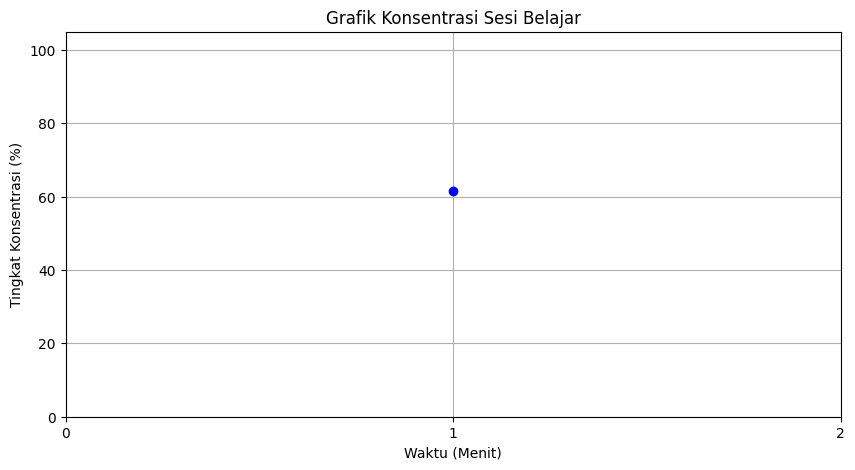

In [4]:
import cv2
import dlib
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist
import pygame

# =============================================================================
# Konfigurasi dan Inisialisasi
# =============================================================================
try:
    pygame.mixer.init()
    alert_sound = pygame.mixer.Sound("terdeteksi_mengantuk_fast.wav") # Ganti dengan nama file suara Anda
    print("[INFO] File suara 'alert.wav' berhasil dimuat.")
except pygame.error:
    print("\n[WARNING] Gagal memuat file suara. Fitur peringatan suara akan dinonaktifkan.")
    alert_sound = None

# --- Thresholds (Ambang Batas) ---
YAW_THRESHOLD = 25
PITCH_THRESHOLD = 20
DISTRACTION_TIME_THRESHOLD = 3.0
EYE_AR_THRESH = 0.22
EYE_AR_CONSEC_FRAMES = 20
LONG_DISTRACTION_TIME_THRESH = 60.0 # FIX: Ubah ke nilai yang lebih kecil untuk tes, misal 10.0

# --- Variabel untuk Kalibrasi ---
is_calibrated = False
baseline_yaw = 0
baseline_pitch = 0
calibration_samples = []
CALIBRATION_TIME = 5

# --- Variabel untuk Deteksi Kantuk ---
drowsiness_counter = 0
is_drowsy = False

# --- Variabel untuk Peringatan Suara ---
long_distraction_start_time = None
sound_played_for_long_distraction = False

# --- Inisialisasi Model Dlib ---
print("[INFO] Memuat model landmark wajah...")
try:
    face_detector = dlib.get_frontal_face_detector()
    landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    print("[INFO] Model berhasil dimuat.")
except RuntimeError:
    print("\n[ERROR] Gagal memuat 'shape_predictor_68_face_landmarks.dat'.")
    exit()

# --- Variabel Logika Fokus ---
is_focused = True
distraction_start_time = None
total_focus_time = 0.0
focus_session_start_time = time.time()

# --- Variabel untuk Grafik ---
concentration_data = []
session_start_time = time.time()
focus_in_minute = 0
start_minute_time = time.time()

# =============================================================================
# Fungsi Helper (Tidak ada perubahan di sini)
# =============================================================================
def get_head_pose(shape, frame_dims):
    # ... (kode fungsi ini tetap sama)
    model_points = np.array([
        (0.0, 0.0, 0.0), (0.0, -330.0, -65.0), (-225.0, 170.0, -135.0),
        (225.0, 170.0, -135.0), (-150.0, -150.0, -125.0), (150.0, -150.0, -125.0)
    ])
    image_points = np.array([
        (shape.part(30).x, shape.part(30).y), (shape.part(8).x, shape.part(8).y),
        (shape.part(36).x, shape.part(36).y), (shape.part(45).x, shape.part(45).y),
        (shape.part(48).x, shape.part(48).y), (shape.part(54).x, shape.part(54).y)
    ], dtype="double")
    focal_length = frame_dims[1]
    center = (frame_dims[1]/2, frame_dims[0]/2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]], [0, focal_length, center[1]], [0, 0, 1]], dtype="double"
    )
    dist_coeffs = np.zeros((4, 1))
    (success, rotation_vector, translation_vector) = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
    )
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    sy = np.sqrt(rotation_matrix[0, 0] ** 2 + rotation_matrix[1, 0] ** 2)
    singular = sy < 1e-6
    if not singular:
        x = np.arctan2(rotation_matrix[2, 1], rotation_matrix[2, 2])
        y = np.arctan2(-rotation_matrix[2, 0], sy)
        z = np.arctan2(rotation_matrix[1, 0], rotation_matrix[0, 0])
    else:
        x = np.arctan2(-rotation_matrix[1, 2], rotation_matrix[1, 1])
        y = np.arctan2(-rotation_matrix[2, 0], sy)
        z = 0
    pitch, yaw, roll = np.degrees([x, y, z])
    return pitch, yaw, roll

def calculate_ear(eye_landmarks):
    A = dist.euclidean(eye_landmarks[1], eye_landmarks[5])
    B = dist.euclidean(eye_landmarks[2], eye_landmarks[4])
    C = dist.euclidean(eye_landmarks[0], eye_landmarks[3])
    ear = (A + B) / (2.0 * C)
    return ear

def plot_concentration_graph(data):
    # ... (kode fungsi ini tetap sama)
    if not data:
        print("Tidak ada data konsentrasi untuk ditampilkan.")
        return
    minutes = [item[1] / 60 for item in data]
    concentration_levels = [item[0] for item in data]
    plt.figure(figsize=(10, 5))
    plt.plot(minutes, concentration_levels, marker='o', linestyle='-', color='b')
    plt.title('Grafik Konsentrasi Sesi Belajar')
    plt.xlabel('Waktu (Menit)')
    plt.ylabel('Tingkat Konsentrasi (%)')
    plt.grid(True)
    plt.ylim(0, 105)
    if minutes:
        plt.xticks(np.arange(0, max(minutes) + 1, 1.0))
    plt.show()

# =============================================================================
# Loop Utama Aplikasi
# =============================================================================
print("[INFO] Memulai webcam... Tekan 'q' untuk keluar.")
cap = cv2.VideoCapture(0)
time.sleep(1.0)

calibration_start_time = time.time()

while True:
    success, frame = cap.read()
    if not success:
        break

    frame = cv2.flip(frame, 1)
    height, width, _ = frame.shape
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    faces = face_detector(gray, 0)
    
    if not is_calibrated:
        # ... (Logika Kalibrasi, tidak ada perubahan di sini)
        cv2.putText(frame, "LIHAT LURUS KE LAYAR UNTUK KALIBRASI", (50, height // 2 - 50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        remaining_time = CALIBRATION_TIME - (time.time() - calibration_start_time)
        cv2.putText(frame, f"Waktu tersisa: {int(remaining_time) + 1}", (50, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)

        if len(faces) > 0:
            landmarks = landmark_predictor(gray, faces[0])
            pitch, yaw, _ = get_head_pose(landmarks, (height, width))
            calibration_samples.append((pitch, yaw))
            
        if time.time() - calibration_start_time >= CALIBRATION_TIME:
            if calibration_samples:
                avg_pitch = np.mean([sample[0] for sample in calibration_samples])
                avg_yaw = np.mean([sample[1] for sample in calibration_samples])
                baseline_pitch = avg_pitch
                baseline_yaw = avg_yaw
                is_calibrated = True
                print(f"[INFO] Kalibrasi Selesai! Baseline Pitch: {baseline_pitch:.2f}, Baseline Yaw: {baseline_yaw:.2f}")
            else:
                print("[WARNING] Wajah tidak terdeteksi. Mengulang kalibrasi...")
                calibration_start_time = time.time()
    
    else: # --- Logika Utama SETELAH Kalibrasi ---
        current_frame_status = "TIDAK ADA WAJAH"
        is_currently_focused = False
        is_drowsy = False # Reset is_drowsy di setiap frame

        if len(faces) > 0:
            face = faces[0]
            landmarks = landmark_predictor(gray, face)
            pitch, yaw, roll = get_head_pose(landmarks, (height, width))
            
            # --- DETEKSI MATA TERTUTUP ---
            left_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)], np.int32)
            right_eye_pts = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)], np.int32)
            left_ear = calculate_ear(left_eye_pts)
            right_ear = calculate_ear(right_eye_pts)
            ear = (left_ear + right_ear) / 2.0

            if ear < EYE_AR_THRESH:
                drowsiness_counter += 1
                if drowsiness_counter >= EYE_AR_CONSEC_FRAMES:
                    is_drowsy = True
                    cv2.putText(frame, "!!! MENGANTUK !!!", (50, height - 100),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 165, 255), 3)
            else:
                drowsiness_counter = 0

            # --- KONDISI FOKUS YANG SUDAH DIGABUNG ---
            # FIX 1: Hapus blok logika duplikat. Cukup satu blok ini.
            if abs(yaw - baseline_yaw) > YAW_THRESHOLD or abs(pitch - baseline_pitch) > PITCH_THRESHOLD or is_drowsy:
                current_frame_status = "TIDAK FOKUS"
                is_currently_focused = False
            else:
                current_frame_status = "FOKUS"
                is_currently_focused = True
        
        # --- Logika Waktu dan Peringatan ---
        if is_currently_focused:
            if not is_focused: # Baru mulai fokus lagi
                focus_session_start_time = time.time()
            is_focused = True
            distraction_start_time = None
            long_distraction_start_time = None # Reset timer suara saat kembali fokus
            focus_in_minute += 1
        else: # Jika tidak fokus
            if is_focused: # Baru mulai terdistraksi
                total_focus_time += time.time() - focus_session_start_time
                # FIX 2: Mulai timer suara HANYA saat transisi ke tidak fokus
                long_distraction_start_time = time.time()
                sound_played_for_long_distraction = False
            is_focused = False

            if distraction_start_time is None:
                distraction_start_time = time.time()
            else:
                distraction_duration = time.time() - distraction_start_time
                if distraction_duration > DISTRACTION_TIME_THRESHOLD:
                    cv2.putText(frame, "PERHATIAN TERGANGGU!", (50, height - 50),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
            
            # FIX 3: Logika untuk memainkan suara
            if long_distraction_start_time is not None:
                long_distraction_duration = time.time() - long_distraction_start_time
                if long_distraction_duration > LONG_DISTRACTION_TIME_THRESH and not sound_played_for_long_distraction:
                    print("[ALERT] Pengguna tidak fokus selama 1 menit. Memainkan suara.")
                    if alert_sound:
                        alert_sound.play()
                    sound_played_for_long_distraction = True

        # --- Tampilkan Informasi dan Visualisasi ---
        # ... (sisa kode visualisasi sama seperti sebelumnya, tapi pastikan tidak duplikat)
        current_total_focus = total_focus_time
        if is_focused:
            current_total_focus += time.time() - focus_session_start_time
        status_color = (0, 255, 0) if is_currently_focused else (0, 0, 255)
        cv2.putText(frame, f"Status: {current_frame_status}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, status_color, 2)
        cv2.putText(frame, f"Total Fokus: {int(current_total_focus)} detik", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        if len(faces) > 0:
            cv2.putText(frame, f"Yaw: {yaw:.2f}", (width - 150, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, f"Pitch: {pitch:.2f}", (width - 150, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            cv2.putText(frame, f"EAR: {ear:.2f}", (width - 150, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
            end_point_yaw = (int(landmarks.part(30).x + 200 * np.sin(np.radians(yaw))),
                             int(landmarks.part(30).y - 200 * np.cos(np.radians(yaw))))
            cv2.line(frame, (landmarks.part(30).x, landmarks.part(30).y), end_point_yaw, (0, 255, 0), 2)
            cv2.drawContours(frame, [left_eye_pts], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [right_eye_pts], -1, (0, 255, 0), 1)
        
        # Logika Grafik (tidak berubah)
        if time.time() - start_minute_time > 60:
            fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 30
            total_frames_in_minute = 60 * fps
            concentration_percent = min(100, (focus_in_minute / total_frames_in_minute) * 100)
            elapsed_session_time = time.time() - session_start_time
            concentration_data.append((concentration_percent, elapsed_session_time))
            focus_in_minute = 0
            start_minute_time = time.time()
            print(f"[LOG] Menit {len(concentration_data)}: Konsentrasi {concentration_percent:.2f}%")
    
    cv2.imshow("FocusFlow Monitor", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# =============================================================================
# Cleanup dan Tampilkan Hasil Akhir
# =============================================================================
print("[INFO] Menghentikan program...")
cap.release()
cv2.destroyAllWindows()

print("[INFO] Menampilkan grafik konsentrasi sesi...")
plot_concentration_graph(concentration_data)